In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, WIKIMEDIA, CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM
from bokeh.io import output_notebook, show


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samirashafiei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samirashafiei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samirashafiei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import Data

In [9]:
#Imporst the data 
#The scrapped data is in json format

# create separate dataframes from data
df_atlanta=pd.read_json('atlanta.json')
df_austin=pd.read_json('austin.json')
df_chicago=pd.read_json('chicago.json')
df_houston=pd.read_json('houston.json')
df_la=pd.read_json('la.json')
df_ny=pd.read_json('ny.json')
df_oc=pd.read_json('oc.json')
df_sandiego=pd.read_json('sandiego.json')
df_seattle=pd.read_json('seattle.json')
df_sf=pd.read_json('sf.json')

In [10]:
# function to update locations to main city name, all axcept 'United States'
def update_location(dataframe, updated_location):
    dataframe['location'] = np.where(~dataframe['location'].str.contains("United States", na=False), updated_location, dataframe['location'])

#update locations
update_location(df_atlanta, 'atlanta, ga')
update_location(df_austin, 'austin, tx')
update_location(df_chicago, 'chicago, il')
update_location(df_houston, 'houston, tx')
update_location(df_la, 'los angeles, ca')
update_location(df_ny, 'new york, ny')
update_location(df_oc, 'orange county, ca')
update_location(df_sandiego, 'san diego, ca')
update_location(df_seattle, 'seattle, wa')
update_location(df_sf, 'san francisco, ca')

#combine all to one dataframe
df=pd.concat([df_atlanta,df_austin,df_chicago, df_houston, df_la, df_ny, df_oc, df_sandiego, df_seattle, df_sf],axis=0) 

df.shape

(6123, 9)

## Preprocessing-Cleaning the Data

Data cleaning steps were performed on the data 
- Dropped insignificant columns - reviews , id , postedAt , scrapedAt , url
- Removed case sensitivity from the data
- Removed duplicates
- Checked for missing values
- Divided the dataset into Senior vs Non-Senior positions


In [11]:
# drop unnecessary columns
df = df.drop(columns=['reviews', 'id', 'postedAt', 'scrapedAt', 'url'])

# make lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

# delete duplicate rows
df = df.drop_duplicates()

# create senior jobs
senior = df[((df['positionName'].str.contains('senior'))
             | (df['positionName'].str.contains('sr.')))]

# all remote jobs (positionName has either 'remote' or 'virtual')
remote = df[(df['positionName'].str.contains('remote')) | (
    df['positionName'].str.contains('virtual')) | (df['location'].str.contains('united states'))]

# check for any missing values
df.isnull().sum()


positionName    0
company         0
location        0
description     0
dtype: int64

In [12]:
# drop senior rows
df_nonsenior = (pd.merge(df,senior, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))

df_nonsenior.shape

(3896, 4)

## Exploratory Data Analysis

In [13]:
# remote vs in person

remote_chart = remote.groupby('location').count()
remote_chart = remote_chart.drop(columns=['company', 'description'])
remote_chart = remote_chart.rename(columns={'positionName':'count_remote'})
remote_chart.reset_index()

df_chart = df.groupby('location').count()
df_chart = df_chart.drop(columns=['company', 'description'])
df_chart = df_chart.rename(columns={'positionName':'count_all'})
df_chart.reset_index()

df_remote_and_all= df_chart.merge(remote_chart, how='inner', on='location')

df_remote_and_all = df_remote_and_all.drop(index='united states')

df_remote_and_all

,count_all,count_remote
location,,
"atlanta, ga",702,36
"austin, tx",357,22
"chicago, il",756,34
"houston, tx",378,16
"los angeles, ca",578,19
"new york, ny",830,33
"orange county, ca",328,10
"san diego, ca",230,6
"san francisco, ca",475,10


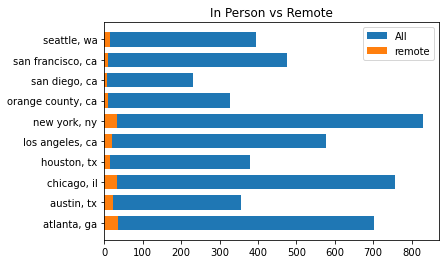

In [14]:
labels = df_remote_and_all.index
width = 0.7   
fig, ax = plt.subplots()
ax.barh(labels, df_remote_and_all['count_all'], width, label='All')
ax.barh(labels, df_remote_and_all['count_remote'], width, label='remote')
ax.set_title('In Person vs Remote')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Jobs per City')

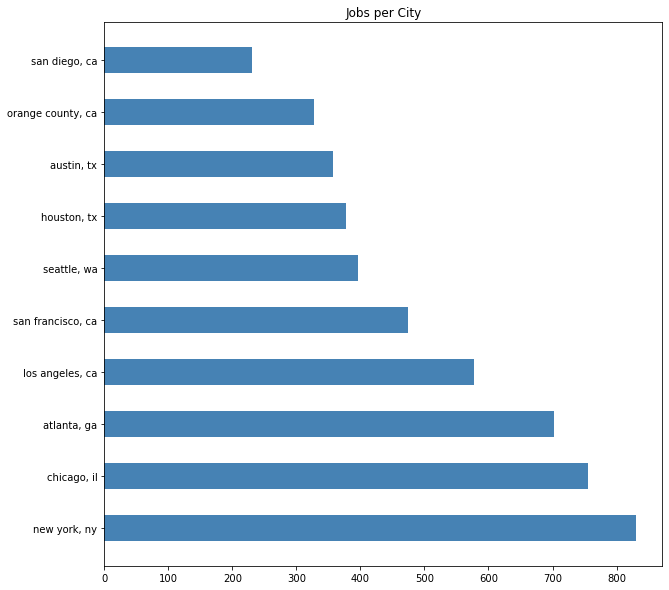

In [15]:
# bar chart of number of jobs per city

df_map_chart = df_remote_and_all.drop(columns = 'count_remote')
df_map_chart = df_map_chart.sort_values(by='count_all',ascending=False)

plt.figure(figsize=(10,10))
plt.barh(df_map_chart.index,df_map_chart['count_all'], height = 0.5, color='steelblue')

plt.title("Jobs per City")

## Analysis

- Creating list of skills
- Building N-Grams
   - Uni Grams
   - Bi Grams
   - Tri Grams

In [16]:
# Create list of skills (each skill group is divieded into 1 or 2 word list)

list1_1 = [('sql',) , ('mysql',) , ('python',), ('oracle',), ('sybase',), ('tableau',), ('nosql',), ('weka',), ('r',), ('hadoop',), ('sas',), ('spss',), ('matlab',)]
list1_2 = [('microsoft', 'excel'), ('google', 'analytics'), ('power', 'bi')]
list2_1 = [('mathematics',), ('etl',), ('statistical',), ('database',),('vlookup',),('querying',),('testing',),('reporting',),('dashboards',)]
list2_2 = [('data', 'modeling'), ('data', 'collection'), ('data', 'cleaning'), ('data', 'visualization'), ('pattern', 'recognition'), ('machine', 'learning'), ('data', 'processing'), ('data', 'mining'), ('business', 'analysis'), ('business', 'strategy'), ('big', 'data'), ('predictive', 'analysis'), ('data', 'extraction'),('data','warehousing')]
list3_1 = [('communication,'), ('collaboration,'), ('presentation,'),('troubleshoot')]
list3_2 = [('critical', 'thinking'), ('public', 'speaking'), ('attention', 'detail'), ('problem', 'solving'), ('project', 'management'), ('team', 'work'), ('decision', 'making'), ('logical', 'thinking')]

### N - Grams 

In [17]:
# n - grams set up 

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(df_nonsenior['description'].tolist())))

### Uni Grams

In [18]:
uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()
uni_grams = uni_grams.rename(columns={0: 'counts'})
uni_grams.head(10)

# Uni gram does NOT provide sufficient information 

,counts
"(data,)",28528
"(business,)",18365
"(team,)",10713
"(experience,)",10647
"(work,)",10541
"(management,)",7234
"(analysis,)",6958
"(process,)",6834
"(project,)",6735
"(skill,)",6372


In [19]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          

df_list1_1.head(100)

# the most desired kill is sql

,index,counts
0,"(sql,)",2325
1,"(tableau,)",1170
2,"(python,)",817
3,"(r,)",537
4,"(oracle,)",445
5,"(spss,)",137
6,"(mysql,)",59
7,"(hadoop,)",48
8,"(nosql,)",30
9,"(matlab,)",21


In [20]:
# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        

df_list2_1.head(100)

# the most desired skill is reporting

,index,counts
0,"(reporting,)",3972
1,"(database,)",2041
2,"(testing,)",1551
3,"(statistical,)",1244
4,"(mathematics,)",490
5,"(etl,)",349
6,"(querying,)",130
7,"(vlookup,)",41


In [21]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        

df_list3_1.head(100)

# there is no skills from this set of skills.

,index


In [22]:
# Bi-Grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 
two_grams.head(20)

#We get a good amount of information

,counts
"(year, experience)",2211
"(data, analyst)",1709
"(business, analyst)",1673
"(equal, opportunity)",1543
"(sexual, orientation)",1469
"(national, origin)",1427
"(data, analysis)",1420
"(gender, identity)",1244
"(opportunity, employer)",1204
"(data, analytics)",1105


In [23]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(power, bi)",521
1,"(microsoft, excel)",245
2,"(google, analytics)",126


In [24]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",837
1,"(business, analysis)",491
2,"(data, collection)",394
3,"(machine, learning)",273
4,"(data, mining)",247
5,"(data, modeling)",244
6,"(data, warehousing)",174
7,"(big, data)",154
8,"(business, strategy)",136
9,"(data, processing)",81


In [25]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(project, management)",861
1,"(attention, detail)",503
2,"(problem, solving)",469
3,"(critical, thinking)",275
4,"(decision, making)",243
5,"(team, work)",153
6,"(public, speaking)",10
7,"(logical, thinking)",4


### Tri Grams

In [26]:
# 3 grams 
three_grams = pd.Series(nltk.ngrams(words, 3)).value_counts()[:10000000].to_frame()
three_grams.head(20)

,0
"(equal, opportunity, employer)",1087
"(sexual, orientation, gender)",844
"(without, regard, race)",764
"(race, color, religion)",753
"(orientation, gender, identity)",743
"(regard, race, color)",644
"(employment, without, regard)",555
"(equal, employment, opportunity)",499
"(receive, consideration, employment)",474
"(color, religion, sex)",471


## Creating 3 data frame with different skill types

In [27]:
df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)

tool_list = ['sql', 'tableau', 'python', 'r', 'power bi', 'oracle', 'microsoft excel','spss', 'google analytics', 'mysql','hadoop', 'nosql', 'matlab','sybase', 'weka']
df_tool = df_tool.rename(columns={'index':'skill'})
df_tool['skill'] = tool_list

#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)

hard_list = ['reporting','database','testing','statistical','data visualization', 'business analysis', 'mathematics', 'data collection', 'etl', 'machine learning' , 'data mining', 'data modeling', 'data warehousing', 'big data', 'business strategy','querying', 'data processing', 'data extraction', 'data cleaning', 'vlookup','predictive analysis', 'pattern recognition']
df_hard = df_hard.rename(columns={'index':'skill'})
df_hard['skill'] = hard_list

#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)

soft_list = ['project management', 'attention to detail', 'problem solving', 'critical thinking', 'decision making', 'team work', 'public speaking', 'logical thinking']
df_soft = df_soft.rename(columns={'index':'skill'})
df_soft['skill'] = soft_list

df_tool.head(10)

,skill,counts
0,sql,2325
1,tableau,1170
2,python,817
3,r,537
0,power bi,521
4,oracle,445
1,microsoft excel,245
5,spss,137
2,google analytics,126
6,mysql,59


# Visualizations
- Tool Skills Visualization
- Hard Skills Visualization
- Soft Skills Visualization

### TOOL Skills visualization

<Figure size 432x288 with 0 Axes>

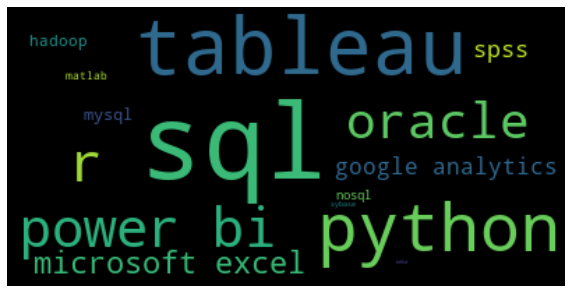

In [28]:
# word cloud
d_tool = dict(zip(df_tool.skill, df_tool.counts))

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_tool)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Tool Skills')

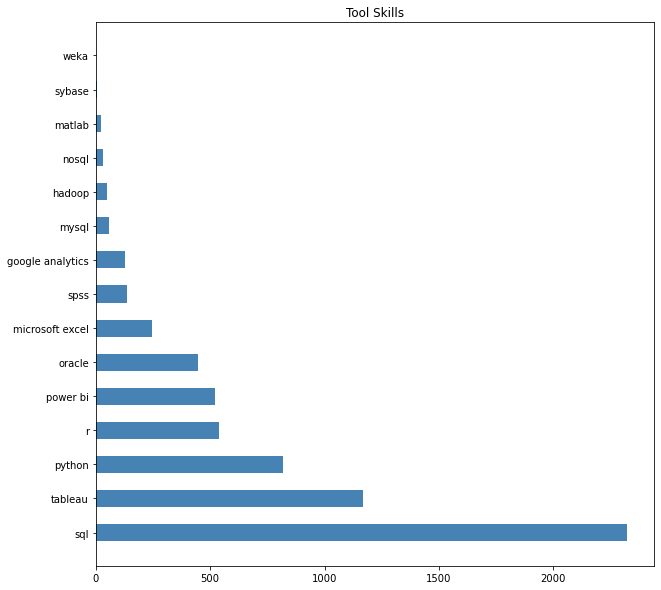

In [29]:
# bar chart
plt.figure(figsize=(10,10))
plt.barh(df_tool['skill'],df_tool['counts'], height = 0.5, color='steelblue')
plt.title("Tool Skills")

### Hard Skills visualization

<Figure size 432x288 with 0 Axes>

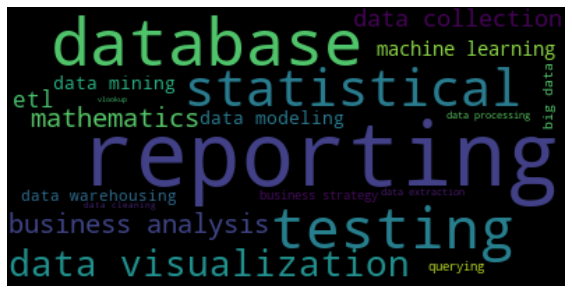

In [30]:
# word cloud
d_hard = dict(zip(df_hard.skill, df_hard.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_hard)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Hard Skills')

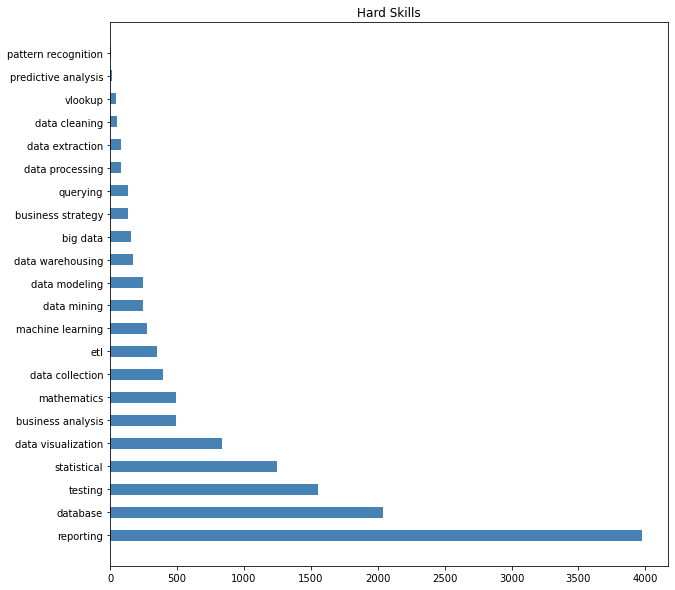

In [31]:
# bar chart
plt.figure(figsize=(10,10))
plt.barh(df_hard['skill'],df_hard['counts'], height = 0.5, color='steelblue')
plt.title("Hard Skills")

### Soft Skills visualization

<Figure size 432x288 with 0 Axes>

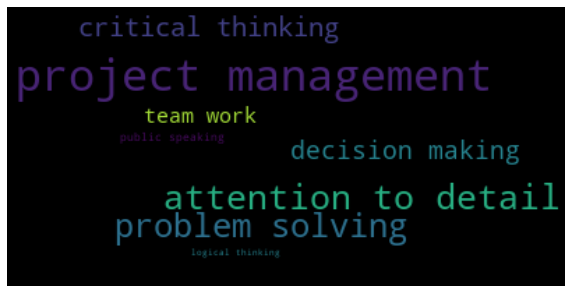

In [32]:
# word cloud
d_soft = dict(zip(df_soft.skill, df_soft.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_soft)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Soft Skills')

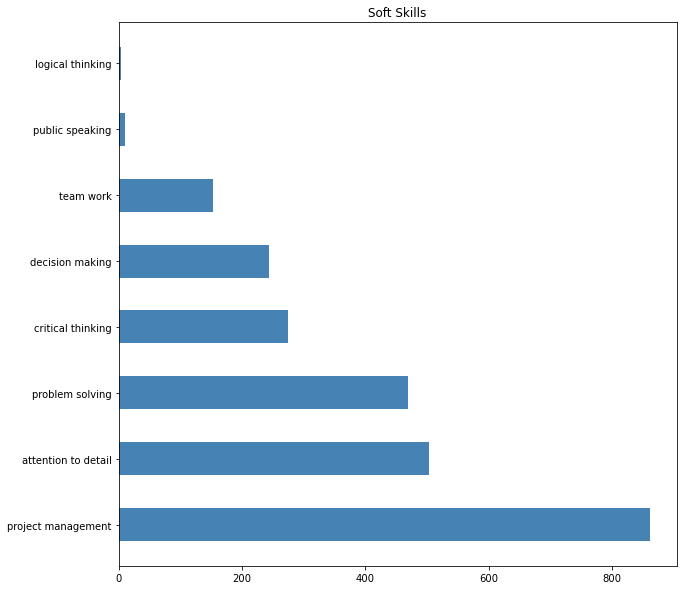

In [33]:
# bar chart
plt.figure(figsize=(10,10))
plt.barh(df_soft['skill'],df_soft['counts'], height = 0.5, color='steelblue')
plt.title("Soft Skills")

# Combining All grams

In [34]:
#create df with all skills
df_skills = pd.DataFrame()

df_skills = df_skills.append(df_tool)
df_skills = df_skills.append(df_hard)
df_skills = df_skills.append(df_soft)

df_skills = df_skills.sort_values(by='counts',ascending=False)
df_skills.head(20)

,skill,counts
0,reporting,3972.0
0,sql,2325.0
1,database,2041.0
2,testing,1551.0
3,statistical,1244.0
1,tableau,1170.0
0,project management,861.0
0,data visualization,837.0
2,python,817.0
3,r,537.0


<Figure size 432x288 with 0 Axes>

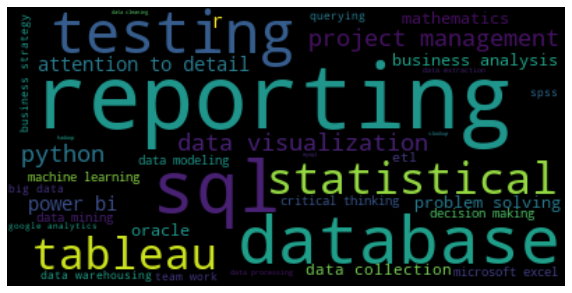

In [35]:
# Visualization for all the grams- word cloud
d = dict(zip(df_skills.skill, df_skills.counts))

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'All Skills')

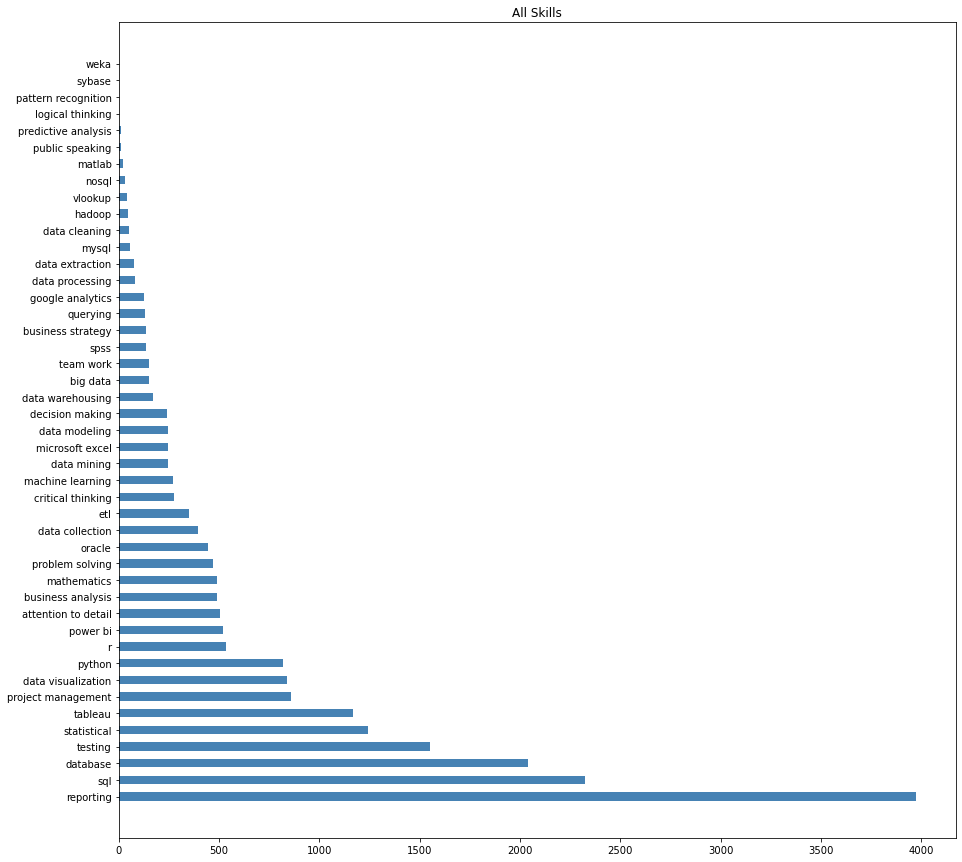

In [36]:
# bar chart- for all the grams
plt.figure(figsize=(15,15))
plt.barh(df_skills['skill'],df_skills['counts'], height = 0.5, color='steelblue')
plt.title("All Skills")

# Departent specific skills
- Finance - Accounting required skills
- Marketing required skills
- Operation required skills


In [37]:
# Create list of skills (each skill group is divieded into 1 or 2 word list)

list1_1 = [('sql',) , ('mysql',) , ('python',), ('oracle',), ('sybase',), ('tableau',), ('nosql',), ('weka',), ('r',), ('hadoop',), ('sas',), ('spss',), ('matlab',)]
list1_2 = [('microsoft', 'excel'), ('google', 'analytics'), ('power', 'bi')]
list2_1 = [('mathematics',), ('etl',), ('statistical',), ('database',),('vlookup',),('querying',),('testing',),('reporting',),('dashboards',)]
list2_2 = [('data', 'modeling'), ('data', 'collection'), ('data', 'cleaning'), ('data', 'visualization'), ('pattern', 'recognition'), ('machine', 'learning'), ('data', 'processing'), ('data', 'mining'), ('business', 'analysis'), ('business', 'strategy'), ('big', 'data'), ('predictive', 'analysis'), ('data', 'extraction'),('data','warehousing')]
list3_1 = [('communication,'), ('collaboration,'), ('presentation,'),('troubleshoot')]
list3_2 = [('critical', 'thinking'), ('public', 'speaking'), ('attention', 'detail'), ('problem', 'solving'), ('project', 'management'), ('team', 'work'), ('decision', 'making'), ('logical', 'thinking')]

### Finance - Accounting

In [38]:
# Finance-Accounting
Finance = df[((df['positionName'].str.contains('finance')) | (df['positionName'].str.contains('financial'))| (df['positionName'].str.contains('account'))| (df['positionName'].str.contains('cost')))]
Finance.head()

# n - grams set up
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(Finance['description'].tolist())))


# Uni grams 
uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()
uni_grams = uni_grams.rename(columns={0: 'counts'})
uni_grams.head(5)

,counts
"(data,)",1065
"(financial,)",940
"(business,)",617
"(analysis,)",495
"(experience,)",438


In [39]:
# SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(5)

,index,counts
0,"(sql,)",70
1,"(oracle,)",67
2,"(tableau,)",51
3,"(python,)",19
4,"(r,)",17


In [40]:
# SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(5)

,index,counts
0,"(reporting,)",265
1,"(statistical,)",68
2,"(database,)",66
3,"(testing,)",34
4,"(mathematics,)",22


In [41]:
# Bi grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
two_grams.head(5)

,counts
"(financial, analyst)",86
"(year, experience)",84
"(data, analysis)",73
"(sexual, orientation)",63
"(national, origin)",58


In [42]:
# SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          
df_list1_2.head(100)

,index,counts
0,"(power, bi)",23
1,"(microsoft, excel)",18
2,"(google, analytics)",3


In [43]:
# SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          
df_list2_2.head(5)

,index,counts
0,"(data, visualization)",25
1,"(business, analysis)",8
2,"(data, mining)",7
3,"(big, data)",6
4,"(machine, learning)",6


In [44]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          
df_list3_2.head(5)

,index,counts
0,"(problem, solving)",30
1,"(project, management)",29
2,"(attention, detail)",23
3,"(decision, making)",16
4,"(critical, thinking)",10


In [45]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(5)

,index,counts
0,"(problem, solving)",30.0
1,"(project, management)",29.0
2,"(attention, detail)",23.0
3,"(decision, making)",16.0
4,"(critical, thinking)",10.0


### Marketing

In [46]:
# Marketing
Marketing = df[(df['positionName'].str.contains('market'))]
Marketing.head()


# n - grams set up

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(Marketing['description'].tolist())))


# Uni grams

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()
uni_grams = uni_grams.rename(columns={0: 'counts'})
uni_grams.head(5)

,counts
"(data,)",1110
"(marketing,)",637
"(business,)",528
"(team,)",410
"(experience,)",353


In [47]:
# SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(5)

,index,counts
0,"(sql,)",74
1,"(tableau,)",50
2,"(python,)",30
3,"(r,)",22
4,"(spss,)",4


In [48]:
# SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(5)

,index,counts
0,"(reporting,)",140
1,"(database,)",53
2,"(statistical,)",48
3,"(testing,)",43
4,"(mathematics,)",24


In [49]:
# Bi grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
two_grams.head(5)

,counts
"(data, analyst)",82
"(marketing, data)",64
"(year, experience)",64
"(market, data)",60
"(data, analytics)",59


In [50]:
# SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          
df_list1_2.head(5)

,index,counts
0,"(google, analytics)",33
1,"(power, bi)",22
2,"(microsoft, excel)",11


In [51]:
# SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          
df_list1_2.head(5)

,index,counts
0,"(google, analytics)",33
1,"(power, bi)",22
2,"(microsoft, excel)",11


In [52]:
# SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          
df_list2_2.head(100)

,index,counts
0,"(data, visualization)",48
1,"(data, mining)",16
2,"(data, modeling)",13
3,"(business, analysis)",13
4,"(data, collection)",9
5,"(big, data)",9
6,"(machine, learning)",8
7,"(data, warehousing)",4
8,"(data, extraction)",4
9,"(data, processing)",4


In [53]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          
df_list3_2.head(5)

,index,counts
0,"(attention, detail)",18
1,"(problem, solving)",17
2,"(project, management)",15
3,"(critical, thinking)",8
4,"(team, work)",8


In [54]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(5)

,index,counts
0,"(attention, detail)",18.0
1,"(problem, solving)",17.0
2,"(project, management)",15.0
3,"(critical, thinking)",8.0
4,"(team, work)",8.0


### Operation

In [55]:
# Operations
Operations = df[(df['positionName'].str.contains('operation'))| (df['positionName'].str.contains('logistic'))| (df['positionName'].str.contains('chain'))]
Operations.head()

# n - grams set up

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(Operations['description'].tolist())))

# Uni grams 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()
uni_grams = uni_grams.rename(columns={0: 'counts'})
uni_grams.head(5)

,counts
"(data,)",1536
"(business,)",882
"(team,)",633
"(experience,)",563
"(work,)",545


In [56]:
# SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(5)

,index,counts
0,"(sql,)",101
1,"(tableau,)",71
2,"(python,)",28
3,"(r,)",14
4,"(oracle,)",6


In [57]:
# SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()
for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(5)

,index,counts
0,"(reporting,)",265
1,"(database,)",86
2,"(testing,)",33
3,"(statistical,)",29
4,"(mathematics,)",20


In [58]:
# Bi grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'}) 
two_grams.head(5)

,counts
"(supply, chain)",320
"(year, experience)",150
"(sexual, orientation)",102
"(national, origin)",98
"(equal, opportunity)",94


In [59]:
# SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          
df_list1_2.head(5)

,index,counts
0,"(power, bi)",32
1,"(microsoft, excel)",19
2,"(google, analytics)",2


In [60]:
# SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          
df_list2_2.head(100)

,index,counts
0,"(data, visualization)",26
1,"(business, analysis)",18
2,"(data, mining)",17
3,"(data, processing)",12
4,"(data, modeling)",9
5,"(big, data)",7
6,"(machine, learning)",7
7,"(data, collection)",4
8,"(business, strategy)",4
9,"(data, warehousing)",3


In [61]:
# SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()
for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          
df_list3_2.head(100)

,index,counts
0,"(project, management)",43
1,"(problem, solving)",31
2,"(attention, detail)",30
3,"(critical, thinking)",16
4,"(team, work)",8
5,"(decision, making)",7
6,"(public, speaking)",1
7,"(logical, thinking)",1


In [62]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
#df_tool = df_tool.append(df_list1_1)
#df_tool = df_tool.append(df_list1_2)
#df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
#df_hard = df_hard.append(df_list2_1)
#df_hard = df_hard.append(df_list2_2)
#df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(5)

,index,counts
0,"(project, management)",43.0
1,"(problem, solving)",31.0
2,"(attention, detail)",30.0
3,"(critical, thinking)",16.0
4,"(team, work)",8.0
